In [1]:
import re

import pandas as pd
from pathlib import Path
from ploting import *

In [2]:
name_re = re.compile("(weak|strong)_scaling-d_(\d+)-n_(\d+)-([\w_]+)_comm-(gpu|cpu)-nodes_(\d+)")

In [3]:
time_re = re.compile("DURATION:\s*(\d+(\.\d+)?(e[+-]\d+)?)")

In [4]:
def create_df(path):
    data = []
    for file in Path(f"{path}/data").iterdir():
        if m := name_re.search(file.name):
            with open(file, "r") as input:
                if t_m := time_re.search(input.read()):
                    duration = t_m.group(1)
                    data.append({"scaling": m.group(1), "dim": m.group(2), "n": m.group(3), "comm_pattern": m.group(4),
                                 "type": m.group(5), "nodes": m.group(6), "time": duration})
    df = pd.DataFrame(data)
    df = df[df.comm_pattern == "stencil"]
    return df.drop(columns=["scaling", "type", "comm_pattern"]).astype({"dim": int, "n": int, "nodes": int, "time": float})

In [5]:
def pivot(df):
    piv = df.pivot(index="nodes", columns=["dim", "n"], values="time")
    return piv[piv.columns.sort_values()]

In [6]:
df_gpu_aware = create_df("horeka")
df_gpu_aware = pivot(df_gpu_aware)
df_gpu_aware

dim           3                                        
n       100       1000      10000     100000    1000000
nodes                                                  
1      0.112879  0.120144  0.149596  0.239627  0.646643
2      0.134566  0.145622  0.174132  0.441400  1.380170
4      0.146901  0.158368  0.885014  0.464111  1.418600
7      0.154621  0.167108  0.207557  0.477451  1.420230
14     0.169777  0.181179  0.210394  0.698554  2.632200
28     0.240523  0.191662  0.852918  0.600332  3.562750
56     0.226601  0.233192  0.921108  0.657446  2.171510

In [7]:
df_gpu_unaware = create_df("horeka-no-gpu-aware-mpi")
df_gpu_unaware = pivot(df_gpu_unaware)
df_gpu_unaware

dim           3                                       
n       100       1000      10000     100000   1000000
nodes                                                 
1      0.217885  0.223601  0.238432  0.330533  1.02927
2      0.230136  0.235043  0.256149  0.389387  1.18321
4      0.236875  0.243379  0.263313  0.404223  1.20454
7      0.245222  0.251083  0.273109  0.413838  1.22144
14     0.272332  0.274380  0.295900  0.441482  1.86673
28     0.298205  0.299598  0.328916  0.482554  2.62198
56     0.358276  0.347082  0.385236  0.559371  1.63961

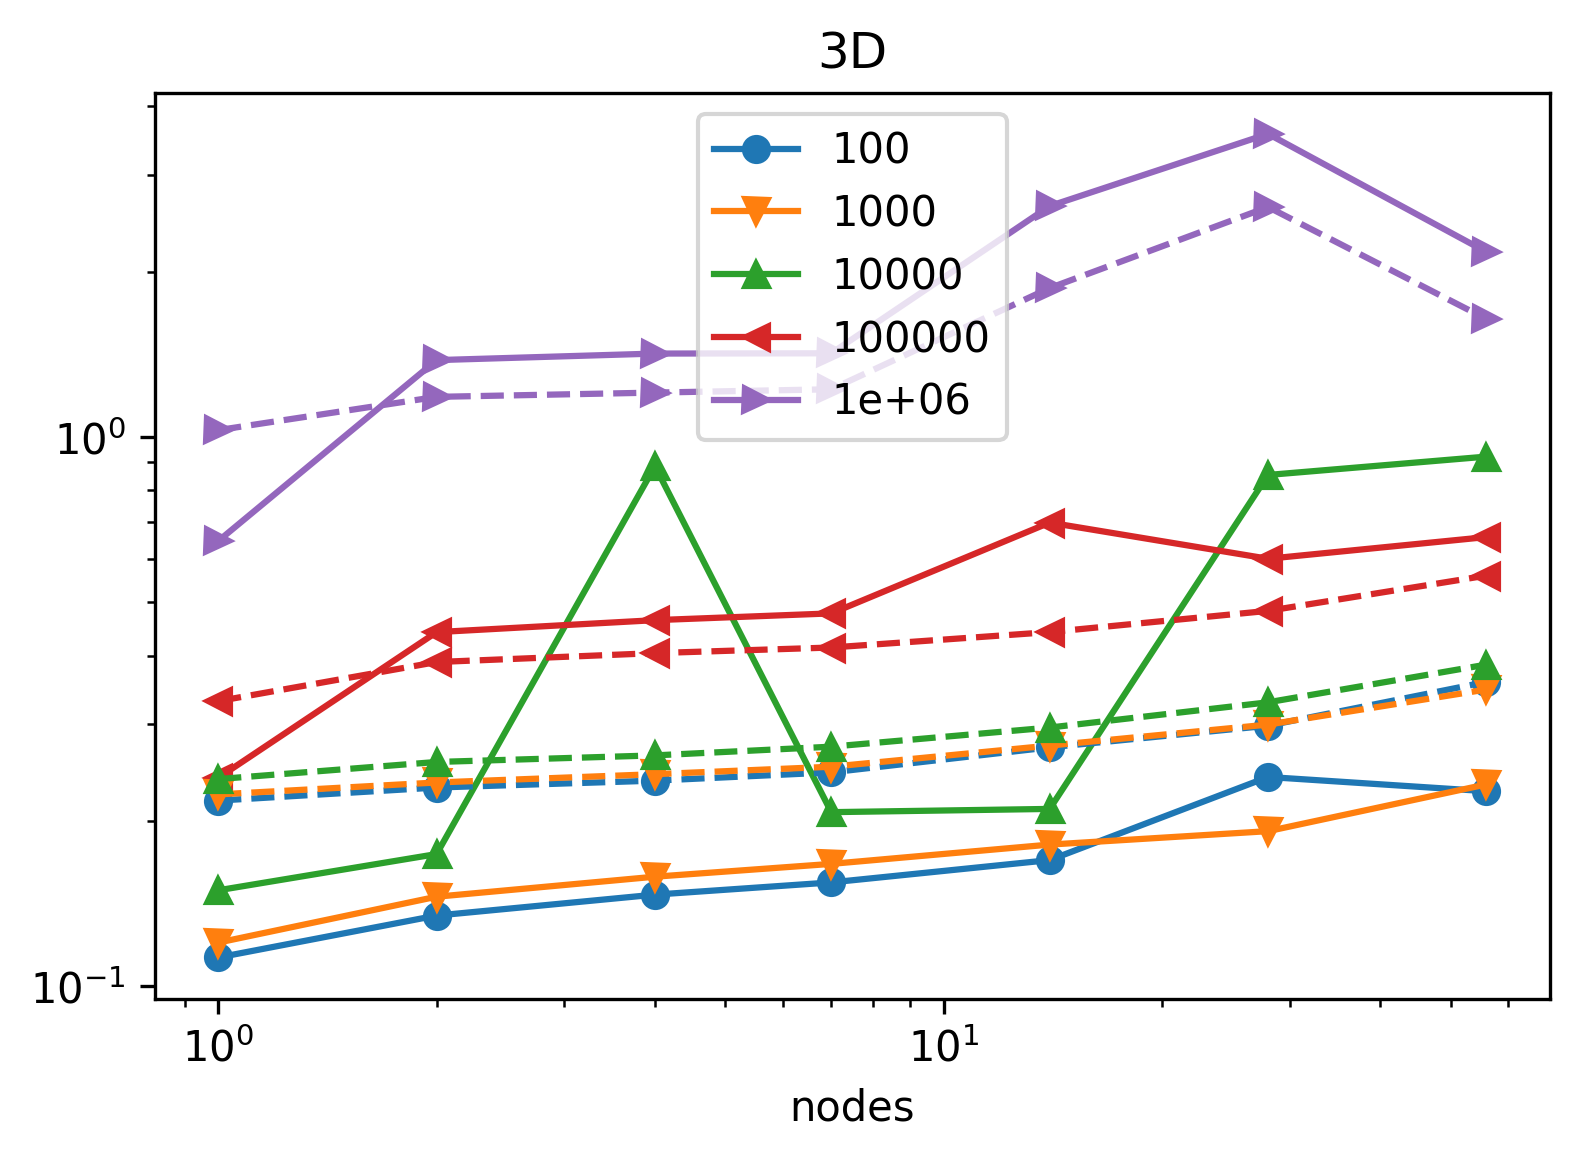

In [8]:
for dim in df_gpu_unaware.columns.levels[0]:
    fig, ax = plt.subplots(dpi=300)
    for piv, is_gpu_aware in [(df_gpu_aware, True), (df_gpu_unaware, False)]:
        _df = piv[dim]
        ax.set_prop_cycle(default_cycler if is_gpu_aware else dashed_cylcer)
        ax.set_title(f"{dim}D")
        _df.plot(ax=ax, legend=False, logx=True, logy=True)
        if is_gpu_aware:
            ax.legend([f"{n:g}" for n in piv.columns.levels[1]])
    #fig.savefig(f"runtime-mpi-comparison-{dim}d.png")